In [155]:
import os
import re
import functools
from collections import Counter, defaultdict
from operator import itemgetter
import pandas as pd
import numpy as np
import nltk
import gensim
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as progress

In [156]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import scale, normalize
from sklearn.cluster import KMeans

In [157]:
# отключаем ворнинги
import warnings
warnings.simplefilter('ignore')

data_dir = "./data"
random_state = 777

%pylab inline
%config InlineBackend.figure_format = 'retina'

# дефолтный размер графиков
from pylab import rcParams
# rcParams['figure.figsize'] = 14,9

Populating the interactive namespace from numpy and matplotlib


In [158]:
def data_path(relative_path):
    return os.path.join(data_dir, relative_path)

def load_reviews(name):
    file_name = 'reviews_' + name + '.csv'
    print('\nLoading reviews from {}...'.format(file_name))
    reviews = pd.read_csv(data_path(file_name))
    print('Total: {}'.format(len(reviews)))
    return reviews

In [159]:
reviews = {
    'raw': load_reviews('filtered'),
    'text_cleaned': load_reviews('text_cleaned'),    
    'sentences_cleaned': load_reviews('sentences_cleaned'),
    'text_lemmatized': load_reviews('text_lemmatized'),     
    'sentences_lemmatized': load_reviews('sentences_lemmatized'),   
}


Loading reviews from reviews_filtered.csv...
Total: 32973

Loading reviews from reviews_text_cleaned.csv...
Total: 32971

Loading reviews from reviews_sentences_cleaned.csv...
Total: 158346

Loading reviews from reviews_text_lemmatized.csv...
Total: 32971

Loading reviews from reviews_sentences_lemmatized.csv...
Total: 158346


In [161]:
print('\n--------\n'.join([
    reviews['raw'].text[0],
    reviews['text_cleaned'].text[0],
    reviews['sentences_cleaned'].text[0],
    reviews['text_lemmatized'].text[0],
    reviews['sentences_lemmatized'].text[0],    
    reviews['sentences_lemmatized'].text_orig[0],    
]))

Экскурсия прошла просто отлично, все понравилось! Было очень увлекательно и интересно, узнали много нового о Ватикане и Риме в целом.
--------
экскурсия прошла отлично понравилось увлекательно интересно узнали нового ватикане риме целом
--------
экскурсия прошла отлично понравилось
--------
экскурсия проходить отлично понравиться увлекательно интересно узнавать новый ватикан рим целое
--------
экскурсия проходить отлично понравиться
--------
Экскурсия прошла просто отлично, все понравилось!


In [162]:
vectorizer = CountVectorizer()
text_bow = vectorizer.fit_transform(reviews['text_cleaned'].text)

In [163]:
list(vectorizer.vocabulary_)[:10]

['экскурсия',
 'прошла',
 'отлично',
 'понравилось',
 'увлекательно',
 'интересно',
 'узнали',
 'нового',
 'ватикане',
 'риме']

In [35]:
len(vectorizer.vocabulary_)

76115

In [36]:
tfidf = TfidfTransformer()
text_idf = tfidf.fit_transform(text_bow)

In [37]:
svd2d = TruncatedSVD(n_components=2, random_state=random_state)
text_svd2d = svd2d.fit_transform(text_idf)

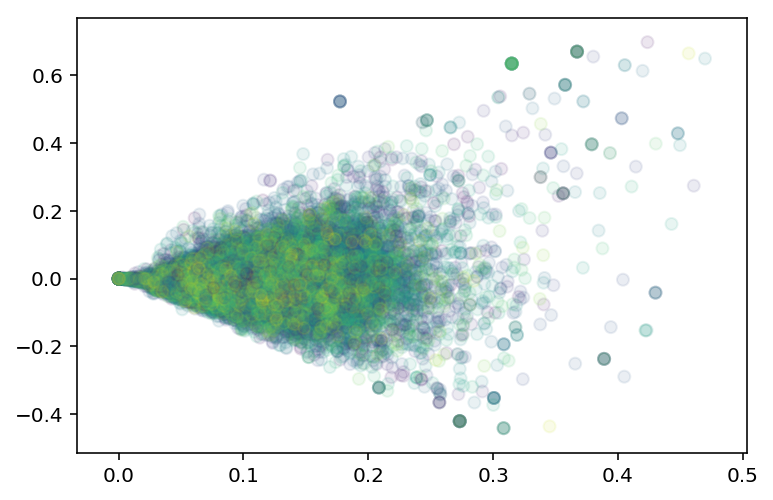

In [38]:
# Рисуем все отзывы
plt.scatter(text_svd2d[:,0], text_svd2d[:,1], c=reviews['text_cleaned'].subject, alpha=0.1);

In [39]:
# Экскурсии с большим числом отзывов
reviews['text_cleaned'].subject.value_counts()[:10]

1805    323
2351    290
8843    269
7104    219
8092    206
8218    168
4148    149
2695    149
3599    148
7487    148
Name: subject, dtype: int64

In [40]:
# Возвращает индексы отзывов на указанную экскурсию
def get_indexes_with_subject(reviews, subject):
    return reviews.loc[reviews.subject==subject].index.ravel()

In [41]:
len(get_indexes_with_subject(reviews['text_cleaned'], 1805))

323

In [42]:
def plot_subj(reviews, subject):
    indexes = get_indexes_with_subject(reviews, subject)
    coords = np.take(text_svd2d, indexes, axis=0)
    rate = reviews.iloc[indexes].rate.ravel()
    plt.scatter(coords[:,0], coords[:,1], c=rate)

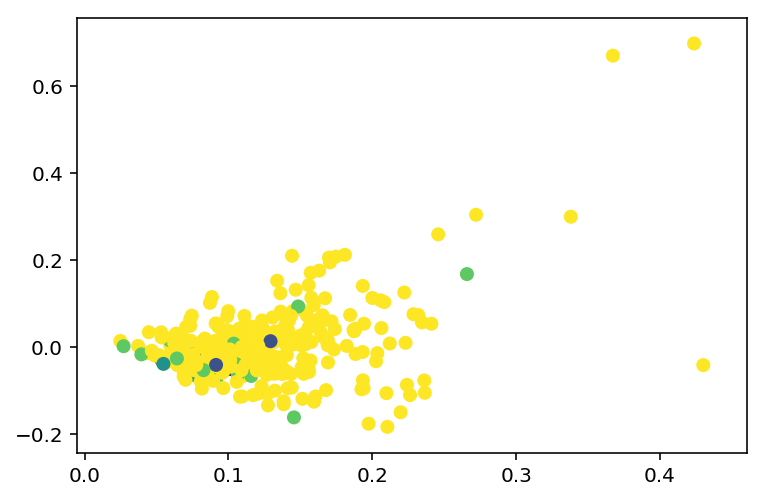

In [43]:
plot_subj(reviews['text_cleaned'], 1805)

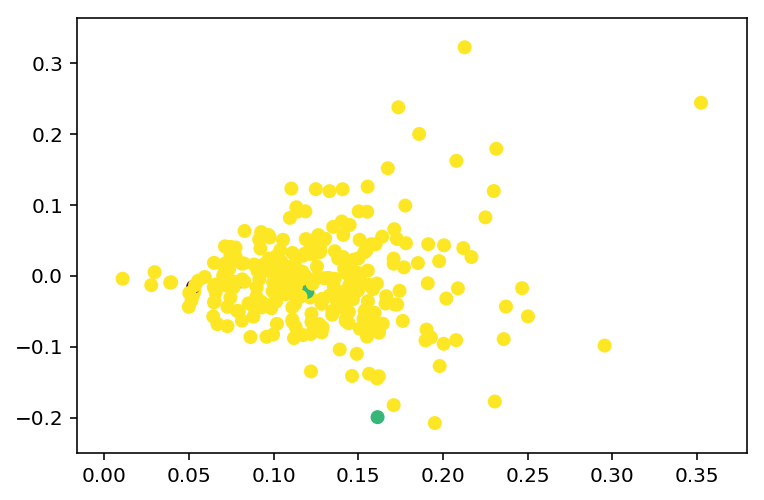

In [44]:
plot_subj(reviews['text_cleaned'], 2351)

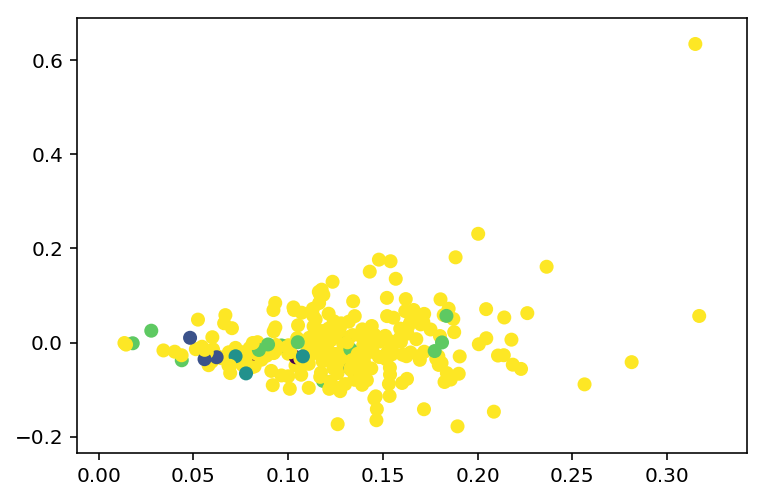

In [45]:
plot_subj(reviews['text_cleaned'], 8843)

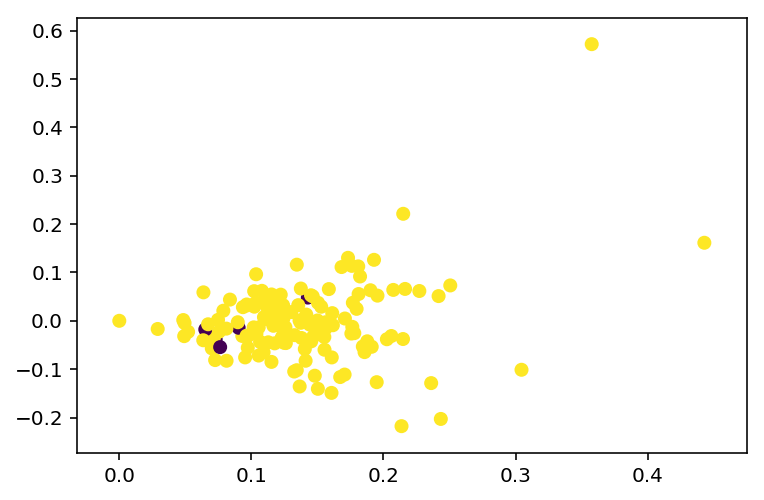

In [46]:
plot_subj(reviews['text_cleaned'], 7487)

In [47]:
vectorizer = CountVectorizer()
text_bow = vectorizer.fit_transform(reviews['text_lemmatized'].text)

In [48]:
list(vectorizer.vocabulary_)[:10]

['экскурсия',
 'проходить',
 'отлично',
 'понравиться',
 'увлекательно',
 'интересно',
 'узнавать',
 'новый',
 'ватикан',
 'рим']

In [49]:
len(vectorizer.vocabulary_)

30491

In [50]:
tfidf = TfidfTransformer()
text_idf = tfidf.fit_transform(text_bow)
svd2d = TruncatedSVD(n_components=2, random_state=random_state)
text_svd2d = svd2d.fit_transform(text_idf)

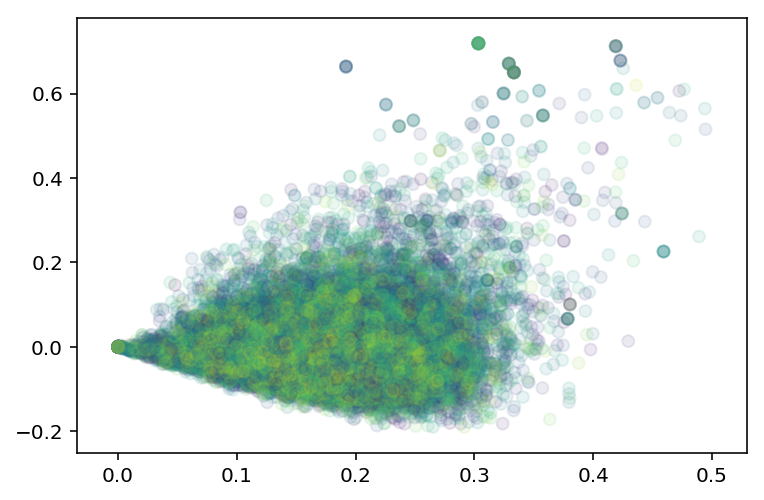

In [51]:
# Рисуем все отзывы
plt.scatter(text_svd2d[:,0], text_svd2d[:,1], c=reviews['text_lemmatized'].subject, alpha=0.1);

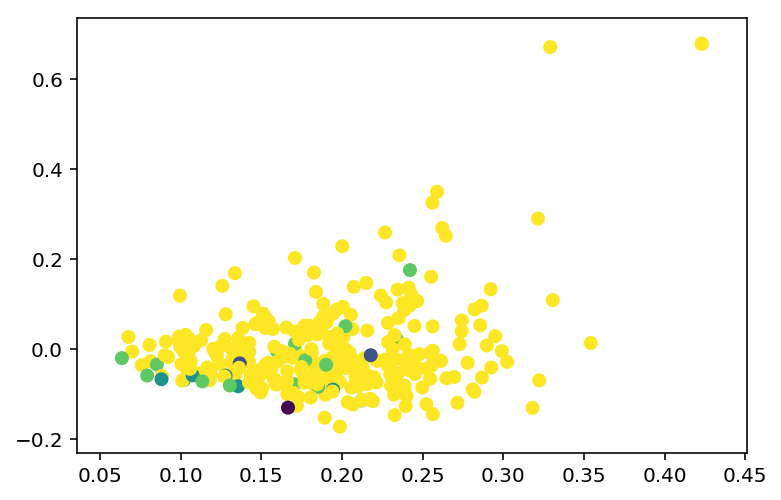

In [52]:
plot_subj(reviews['text_lemmatized'], 1805)

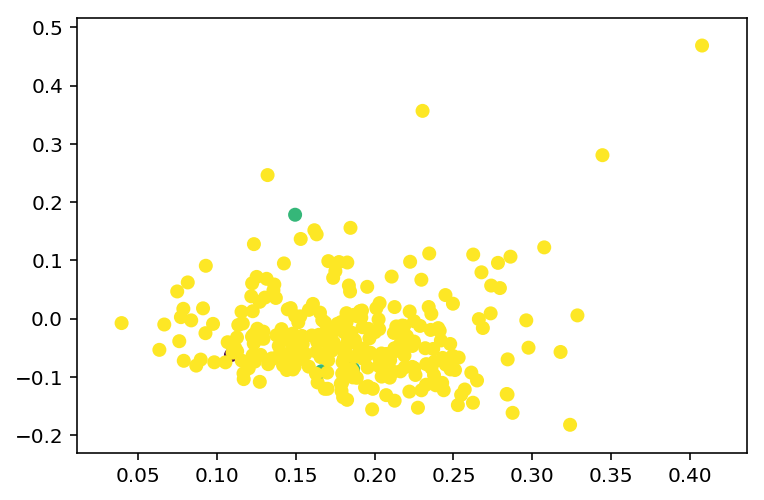

In [53]:
plot_subj(reviews['text_lemmatized'], 2351)

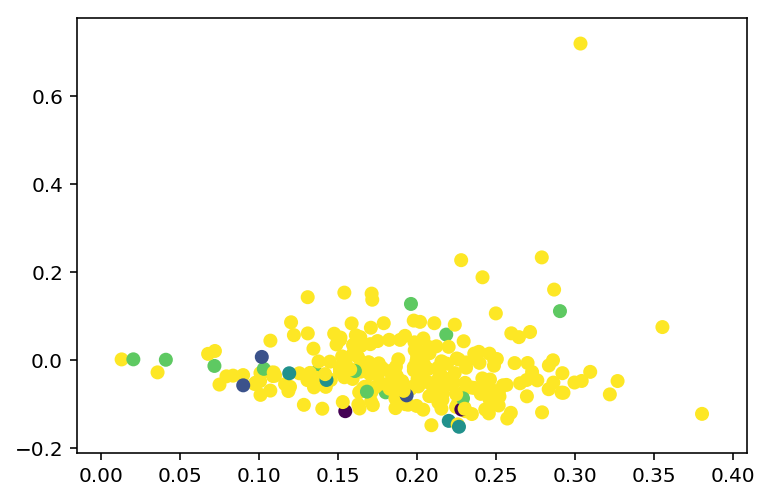

In [54]:
plot_subj(reviews['text_lemmatized'], 8843)

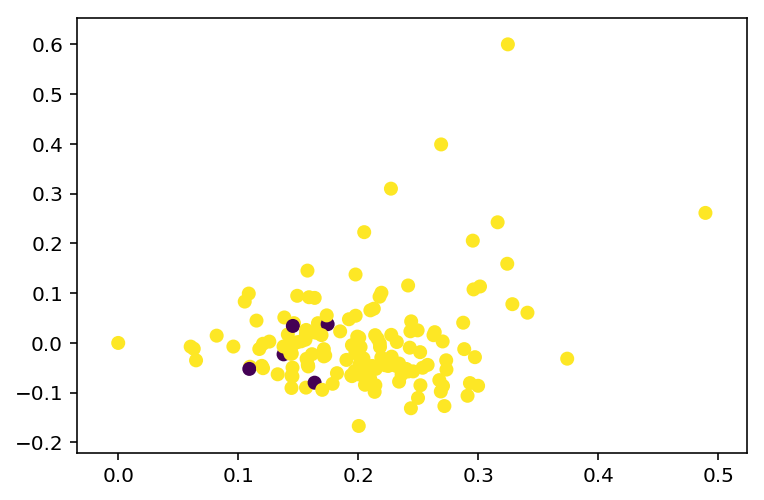

In [55]:
plot_subj(reviews['text_lemmatized'], 7487)

In [56]:
vectorizer = CountVectorizer()
text_bow = vectorizer.fit_transform(reviews['sentences_lemmatized'].text)
tfidf = TfidfTransformer()
text_idf = tfidf.fit_transform(text_bow)
svd2d = TruncatedSVD(n_components=2, random_state=random_state)
text_svd2d = svd2d.fit_transform(text_idf)

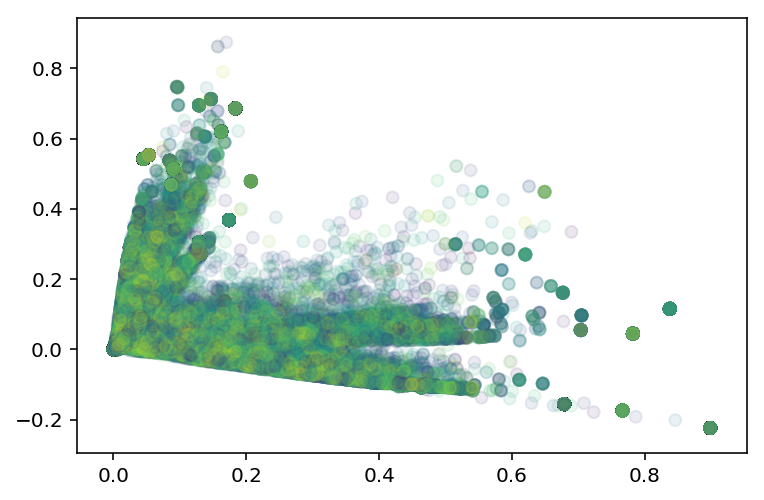

In [57]:
plt.scatter(text_svd2d[:,0], text_svd2d[:,1], c=reviews['sentences_lemmatized'].subject, alpha=0.1);

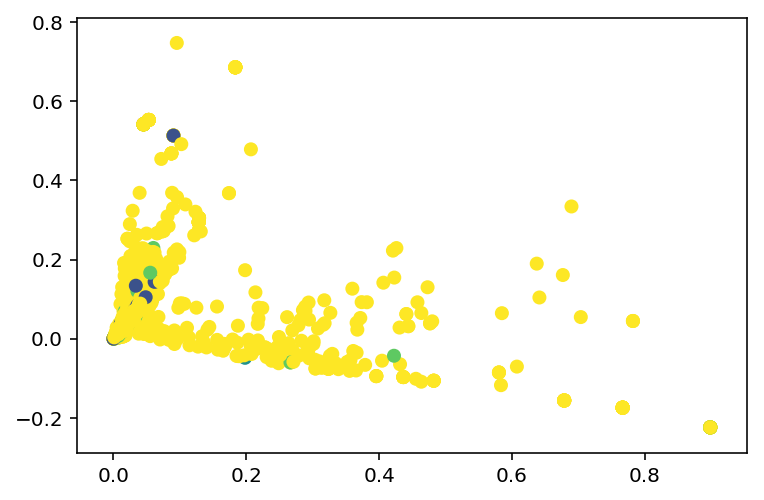

In [58]:
plot_subj(reviews['sentences_lemmatized'], 1805)

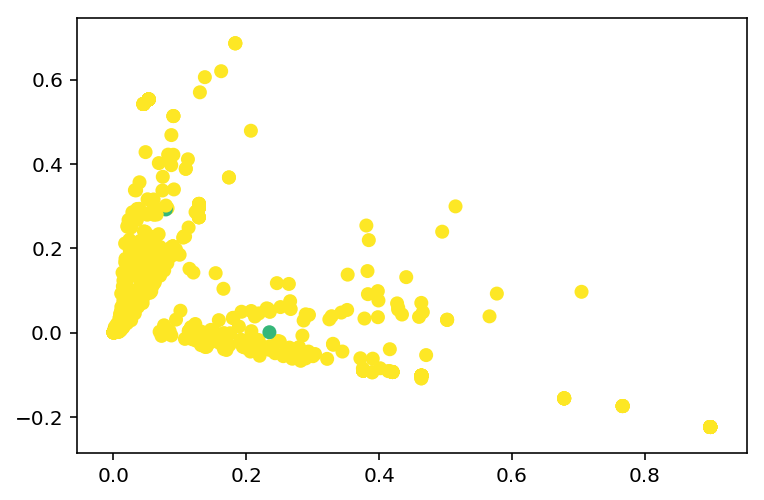

In [59]:
plot_subj(reviews['sentences_lemmatized'], 2351)

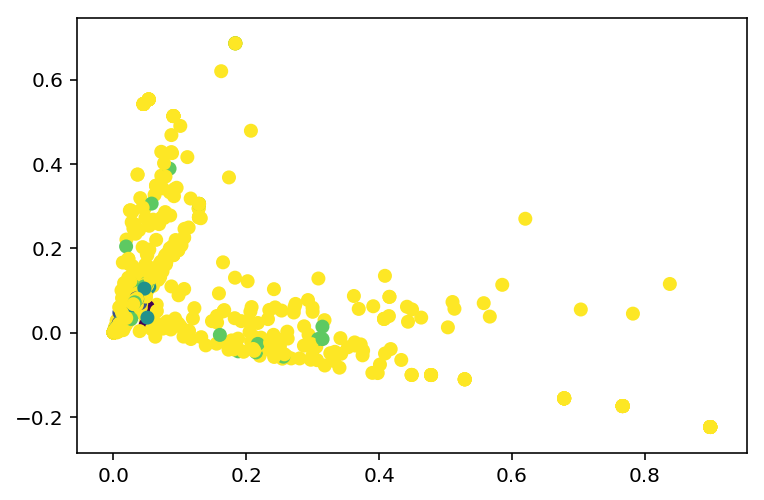

In [60]:
plot_subj(reviews['sentences_lemmatized'], 8843)

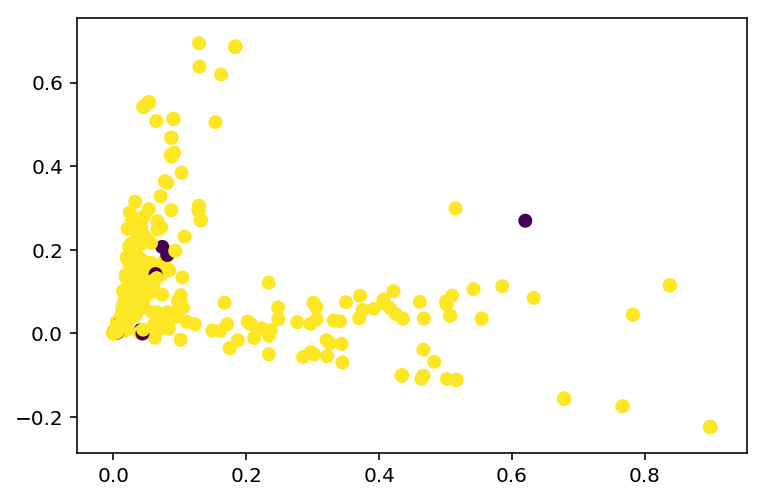

In [61]:
plot_subj(reviews['sentences_lemmatized'], 7487)

In [176]:
# Индекс по отзывам
class ReviewsIndex(object):
    def __init__(self, reviews):
        self.idx2id = {}
        self.id2idx = {}        
        self.idx2subj = {}
        self.subj2idx = defaultdict(list)
        
        for idx, review in reviews.iterrows():
            self.idx2id[idx] = review.id
            self.idx2id[review.id] = idx
            self.idx2subj[idx] = review.subject
            self.subj2idx[review.subject].append(idx)

        
class ReviewsDecomposer(object):
    def __init__(self, reviews, n_components, max_df=1.0, min_df=1, ngram_range=(1, 1)):
        self.reviews = reviews
        self._create_index()
        self._vectorize_text(max_df, min_df, ngram_range)
        self._apply_tfidf()    
        self._decompose(n_components)     
        self._create_similarity_index()
        
    def _create_index(self):
        print('Creating reviews index...')
        self.index = ReviewsIndex(self.reviews)
        
    def _vectorize_text(self, max_df, min_df, ngram_range):
        print('Vectorization...')
        self.vectorizer = CountVectorizer(
            max_df=max_df, 
            min_df=min_df, 
            ngram_range=ngram_range
        )
        self.text_bow = self.vectorizer.fit_transform(self.reviews.text)
        
    def _apply_tfidf(self):
        print('Appling TfIdf transform...')
        self.tfidf = TfidfTransformer()
        self.text_idf = self.tfidf.fit_transform(self.text_bow)
        
    def _decompose(self, n_components):
        print('Decomposing with TruncatedSVD (n_components={})...'.format(n_components))
        self.svd = TruncatedSVD(n_components=n_components, random_state=random_state)
        self.text_svd = normalize(self.svd.fit_transform(self.text_idf))
        
    def _create_similarity_index(self):
        print('Creating similarity index...')
        self.similarity_index = create_similarity_index(self.text_svd)
        
        
def dense_to_bow(matrix):
    return gensim.matutils.Dense2Corpus(matrix.T)


def create_similarity_index(corpus):
    if not gensim.matutils.isbow(corpus):
        corpus = dense_to_bow(corpus)
        
    return gensim.similarities.MatrixSimilarity(corpus)        

In [164]:
%%time
decomposed_sentences_lemmatized = ReviewsDecomposer(reviews['sentences_lemmatized'], 100)

Creating reviews index...
Vectorization...
Appling TfIdf transform...
Decomposing with TruncatedSVD (n_components=100)...
Creating similarity index...
CPU times: user 49.2 s, sys: 2.56 s, total: 51.8 s
Wall time: 48 s


In [170]:
def describe_clusters(reviews, subject, n_clusters=5, count_per_cluster=10):
    # Индексы отзывов (или предложений отзывов) на указанную экскурсию
    indexes = reviews.index.subj2idx[subject]
    indexes_set = set(indexes)
    
    # локальный индекс по глобальному
    {idx: subj_idx for subj_idx, idx in enumerate(indexes)}
    
    # Вектора отзывов
    vectors = normalize(np.take(reviews.text_svd, indexes, axis=0))

    # Кластеризация отзывов
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(vectors)
    
    # Кластер по индексу
    idx2clust = {
        idx: kmeans.labels_[subj_idx] + 1 
        for subj_idx, idx in enumerate(indexes)
    }
    
    # Есть оригинал текста?
    if 'text_orig' in reviews.reviews.columns:
        review_texts = reviews.reviews.text_orig 
    else:
        review_texts = reviews.reviews.text

    # Выводим по [count_per_cluster] бижайших для каждого кластера
    for centroid_n, centroid in enumerate(kmeans.cluster_centers_, 1):
        print('\n{}\n----------'.format(centroid_n))
        
        centroid_similarity = reviews.similarity_index.get_similarities(centroid)
        most_similar = sorted((
            (idx, similarity)
            for idx, similarity
            in enumerate(centroid_similarity)
            if idx in indexes_set
        ), key=itemgetter(1), reverse=True)[:count_per_cluster]
        
        for idx, similarity in most_similar:
            if idx2clust[idx] == centroid_n:
                print('[{:.0f}%] {} ({:.0f})'.format(      
                    similarity * 100,
    #                 reviews.reviews.id[idx],
                    reviews.reviews.text_orig[idx],
                    reviews.reviews.rate[idx],                
                ))    

In [171]:
describe_clusters(
    decomposed_sentences_lemmatized, 
    subject=2351, n_clusters=20, count_per_cluster=3
)


1
----------
[65%] Время пролетело очень быстро, грустно было расставаться. (5)
[61%] Время проведенное во время экскурсии пролетело как мгновение! (5)
[61%] Были опасения, что очень устанем ходить, но время пролетело незаметно. (5)

2
----------
[64%] Нам экскурсия с Айшат очень понравилась. (5)
[64%] Нам очень понравилась экскурсия. (5)
[62%] Нам очень понравилось! (5)

3
----------
[54%] Вот небольшой фотоотчет по экскурсии
https://www.facebook.com/konstantin.barinov.7/posts/974401726011758?pnref=story (5)
[54%] Необыкновенная экскурсия! (5)
[54%] Экскурсия просто необыкновенная! (5)

4
----------
[58%] После этого поднялись на фуникулёре над ночным городом и наслаждались его красотой с высоты. (5)
[58%] Айшат влюбила меня в этот город! (5)
[58%] Я также, как и Айшат, влюбилась в этот город. (5)

5
----------
[58%] Айшат с этой задачей справилась на 200%: мы буквально влюбились в Тбилиси. (5)
[58%] Айшат  полностью погрузила меня в атмосферу Тбилиси. (5)
[57%] В Тбилиси были в нача

In [172]:
describe_clusters(
    decomposed_sentences_lemmatized, 
    subject=7487, n_clusters=10, count_per_cluster=3
)


1
----------
[60%] Ходили целых 5,5 часов по морозу, время пролетело мигом. (5)
[60%] 2,5 часа пролетели просто незаметно. (5)
[59%] 2,5 часа пролетели совершенно незаметно. (5)

2
----------
[64%] Лишний раз это еще подчеркивает и то, что к Сергею очень уважительно относятся коллеги из Казани. (5)
[63%] Сергей обладает невероятными познаниями о Казани. (5)
[63%] Уважаемый, Сергей! (5)

3
----------
[49%] Мы отправились на эту экскурсию практически с поезда. (5)
[49%] Мы отправились на эту экскурсию практически с поезда. (5)
[48%] Были на экскурсии 26 мая! (5)

4
----------
[45%] Эрудиция и знание истории края  очень глубокие и доступны для понимания слушателям с различной подготовкой. (5)
[43%] Так например наличие облика тюльпана как вечного цветка в истории Казани  противоречит справки, что на арабском языке Аллах и тюльпан пишется из одинаковых иероглифов. (4)
[40%] Казань - это не только и не столько архитектура и достопримечательности, но и богатейшая тысячелетняя история. (5)



In [177]:
%%time
decomposed_sentences_lemmatized = ReviewsDecomposer(
    reviews['sentences_lemmatized'], 
    n_components=100,
    max_df=0.8
)

Creating reviews index...
Vectorization...
Appling TfIdf transform...
Decomposing with TruncatedSVD (n_components=100)...
Creating similarity index...
CPU times: user 48.4 s, sys: 2.45 s, total: 50.8 s
Wall time: 46.9 s


In [178]:
describe_clusters(
    decomposed_sentences_lemmatized, 
    subject=2351, n_clusters=20, count_per_cluster=3
)


1
----------
[65%] Время пролетело очень быстро, грустно было расставаться. (5)
[61%] Время проведенное во время экскурсии пролетело как мгновение! (5)
[61%] Были опасения, что очень устанем ходить, но время пролетело незаметно. (5)

2
----------
[64%] Нам экскурсия с Айшат очень понравилась. (5)
[64%] Нам очень понравилась экскурсия. (5)
[62%] Нам очень понравилось! (5)

3
----------
[54%] Вот небольшой фотоотчет по экскурсии
https://www.facebook.com/konstantin.barinov.7/posts/974401726011758?pnref=story (5)
[54%] Необыкновенная экскурсия! (5)
[54%] Экскурсия просто необыкновенная! (5)

4
----------
[58%] После этого поднялись на фуникулёре над ночным городом и наслаждались его красотой с высоты. (5)
[58%] Айшат влюбила меня в этот город! (5)
[58%] Я также, как и Айшат, влюбилась в этот город. (5)

5
----------
[58%] Айшат с этой задачей справилась на 200%: мы буквально влюбились в Тбилиси. (5)
[58%] Айшат  полностью погрузила меня в атмосферу Тбилиси. (5)
[57%] В Тбилиси были в нача

In [179]:
describe_clusters(
    decomposed_sentences_lemmatized, 
    subject=7487, n_clusters=10, count_per_cluster=5
)


1
----------
[60%] Ходили целых 5,5 часов по морозу, время пролетело мигом. (5)
[60%] 2,5 часа пролетели просто незаметно. (5)
[59%] 2,5 часа пролетели совершенно незаметно. (5)
[57%] Время пролетело незаметно. (5)
[57%] Время пролетело незаметно. (5)

2
----------
[64%] Лишний раз это еще подчеркивает и то, что к Сергею очень уважительно относятся коллеги из Казани. (5)
[63%] Сергей обладает невероятными познаниями о Казани. (5)
[63%] Уважаемый, Сергей! (5)
[63%] Кроме того, Сергей очень образован и эрудирован. (5)
[63%] Присоединяюсь к восторженным отзывам о Сергее! (5)

3
----------
[49%] Мы отправились на эту экскурсию практически с поезда. (5)
[49%] Мы отправились на эту экскурсию практически с поезда. (5)
[48%] Были на экскурсии 26 мая! (5)
[48%] Считаю это важным отличием индивидуальных экскурсий от обычных массовых. (4)
[47%] Название экскурсии "За что стоит полюбить Казань" полностью себя оправдывает. (5)

4
----------
[45%] Эрудиция и знание истории края  очень глубокие и до

In [180]:
from gensim.summarization.summarizer import summarize

In [185]:
print(summarize(
    ' '.join(reviews['raw'].loc[reviews['raw'].subject==2351].text), 
    word_count=100
))

Я впервые в Тбилиси и попала в самый жаркий сезон лета.но на экскурсии с Айшат не хотелось спрятаться в тень или побыстрее закончить) потрясающий Мастер своего дела!увлеченная историей,страной,людьми!она влюбила меня в этот прекрасный город!очень жалею,что экскурсия была единственной,но я сама виновата.времени у Айшат больше не было!все расписано на месяцы вперед!но теперь я знаю,есть повод вернуться и погулять не только по Тбилиси,но и по другим красивейшим местам Грузии!и все это именно ее заслуга!оценка 10 баллов)С Уважением,Елена Айшат- отличный гид и замечательный человек!Отличная экскурсия, все продумано до мелочей, мы получили огромное удовольствие!!!


In [187]:
print(summarize(
    ' '.join(reviews['raw'].loc[reviews['raw'].subject==7487].text), 
    word_count=100
)))

Экскурсия с Сергеем запомнится нам надолго!Впечатлений и воспоминаний масса!Не только потому,что было холодно и зябко))А потому,что прогулка  была содержательная,интересная,познавательная и весёлая!Сергей отличный специалист в своём деле,это его на 100%!!!Он смог заинтересовать не только нас,взрослых,но и наших шаловливых девчонок 10,8 и 6 лет))Надеюсь,что Сергею с нами тоже было интересно и весело, Уже порекомендовали его своим знакомым,которые сейчас как раз находятся в Казани.Они тоже остались всецело довольны!Спасибо! Сергей прекрасно знает и любит свой город, получили очень много информации об истории Казани, о религиях этого города, учитывал пожелания и отвечал на все вопросы Экскурсия была замечательная!
